🔧 CONFIGURATION / CONFIGURACIÓN
✅ ENGLISH: Current directory / Directorio actual: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks
✅ ENGLISH: Figures will be saved in / Figuras se guardarán en: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\figures
✅ ESPAÑOL: Resultados se guardarán en / Results will be saved in: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados
✅ ENGLISH: Using device / Usando dispositivo: cpu

📂 ENGLISH: Loading M5 dataset...
📂 ESPAÑOL: Cargando dataset M5...
✅ ENGLISH: Dataset found / Dataset encontrado: ../data/processed/m5_top3_multivariate.csv
✅ ENGLISH: Dataset shape / Dimensiones: (1458, 14)
✅ ESPAÑOL: Productos / Products: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']

🎯 ENGLISH: Selecting top product...
🎯 ESPAÑOL: Seleccionando producto top...
✅ ENGLISH: Product selected / Producto seleccionado: FOODS_3_090_C

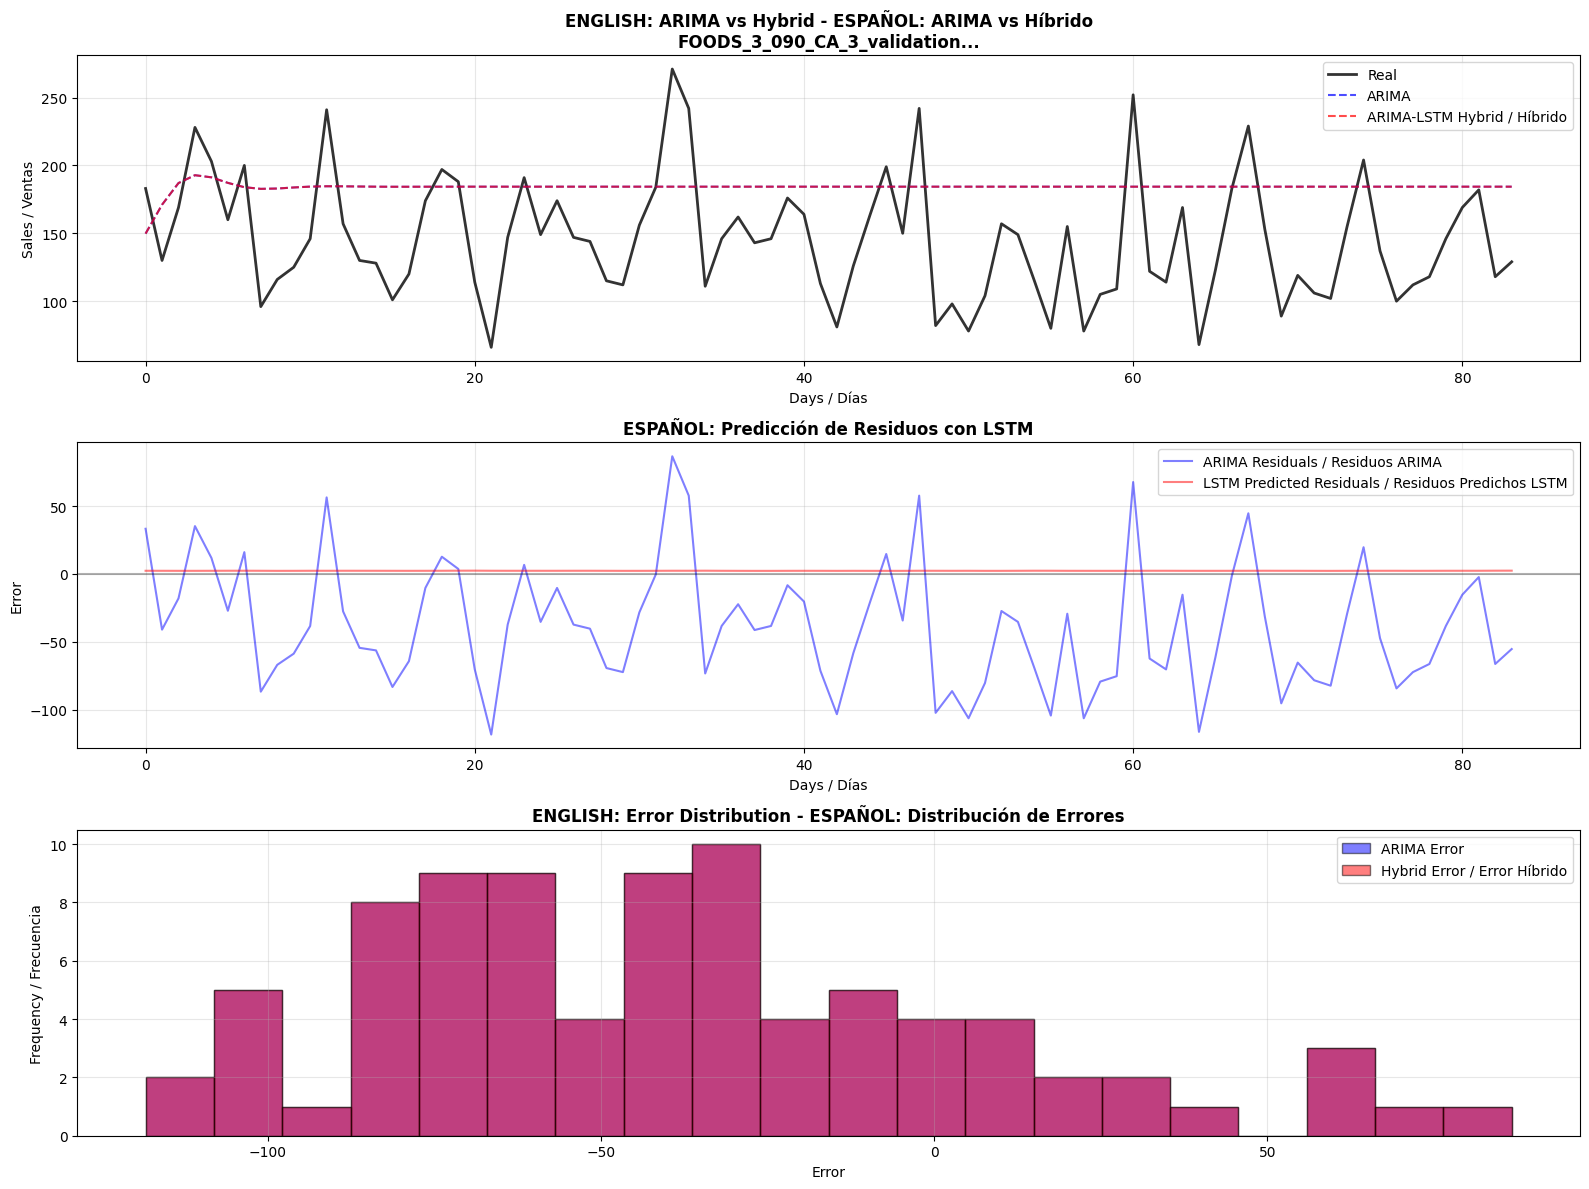


💾 ENGLISH: Saving results...
💾 ESPAÑOL: Guardando resultados...
✅ ENGLISH: Results saved / Resultados guardados: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados\15_hybrid_arima_lstm_results.csv
✅ ESPAÑOL: Copia guardada / Copy saved: 15_hybrid_arima_lstm_results.csv

📊 ENGLISH: COMPARISON WITH PREVIOUS MODELS
📊 ESPAÑOL: COMPARACIÓN CON MODELOS ANTERIORES

📋 ENGLISH: Complete comparison table
📋 ESPAÑOL: Tabla comparativa completa
        Model / Modelo       MAE      RMSE      MAPE
           SARIMA (13) 40.033459 50.164102 29.154078
   LSTM Attention (14) 58.939396 67.167246 51.807766
            ARIMA (15) 50.449019 59.030705 43.854181
Hybrid ARIMA-LSTM (15) 50.804828 59.038284 44.395436

🏆 ENGLISH: BEST MODEL (MAE): SARIMA (13)
🏆 ESPAÑOL: MEJOR MODELO (MAE): SARIMA (13)
   MAE = 40.03

🎯 ENGLISH: ANALYSIS AND CONCLUSIONS
🎯 ESPAÑOL: ANÁLISIS Y CONCLUSIONES

📊 ENGLISH: Experiment Results / Resultados del Experimento:

   ARIMA ONLY / SOLO ARI

In [2]:
# ============================================================
# NOTEBOOK 15: Hybrid ARIMA-LSTM Model
# ============================================================
# ENGLISH: Combine ARIMA (linear) + LSTM (non-linear residuals)
# ESPAÑOL: Combina ARIMA (lineal) + LSTM (residuos no-lineales)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURATION / CONFIGURACIÓN
# ============================================================
print("="*60)
print("🔧 CONFIGURATION / CONFIGURACIÓN")
print("="*60)

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)

# 🟢 Same system as Notebooks 13 and 14 (WORKS!)
# 🟢 Mismo sistema que Notebooks 13 y 14 (¡FUNCIONA!)
FIGURES_DIR = os.path.join(NOTEBOOK_DIR, "figures")  # notebooks/figures/
RESULTS_DIR = os.path.join(NOTEBOOK_DIR, "resultados")  # notebooks/resultados/

# Create folders / Crear carpetas
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"✅ ENGLISH: Current directory / Directorio actual: {NOTEBOOK_DIR}")
print(f"✅ ENGLISH: Figures will be saved in / Figuras se guardarán en: {FIGURES_DIR}")
print(f"✅ ESPAÑOL: Resultados se guardarán en / Results will be saved in: {RESULTS_DIR}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ ENGLISH: Using device / Usando dispositivo: {device}")
print("="*60)

# ============================================================
# LOAD DATASET / CARGAR DATASET
# ============================================================
print("\n📂 ENGLISH: Loading M5 dataset...")
print("📂 ESPAÑOL: Cargando dataset M5...")

def find_dataset():
    """
    ENGLISH: Search for dataset in multiple locations
    ESPAÑOL: Buscar dataset en múltiples ubicaciones
    """
    
    locations = [
        "data/m5_top3_multivariate.csv",
        "data/processed/m5_top3_multivariate.csv",
        "../data/processed/m5_top3_multivariate.csv",
        "m5_top3_multivariate.csv",
        os.path.join(PROJECT_ROOT, "data", "processed", "m5_top3_multivariate.csv"),
        os.path.join(NOTEBOOK_DIR, "data", "m5_top3_multivariate.csv"),
    ]
    
    for path in locations:
        if os.path.exists(path):
            return path
    
    files = glob.glob("**/m5_top3*.csv", recursive=True)
    if files:
        return files[0]
    
    return None

dataset_path = find_dataset()
print(f"✅ ENGLISH: Dataset found / Dataset encontrado: {dataset_path}")

df = pd.read_csv(dataset_path)
df['date'] = pd.to_datetime(df['date'])
print(f"✅ ENGLISH: Dataset shape / Dimensiones: {df.shape}")
print(f"✅ ESPAÑOL: Productos / Products: {df['id'].unique().tolist()}")

# ============================================================
# SELECT TOP PRODUCT / SELECCIONAR PRODUCTO TOP
# ============================================================
print("\n🎯 ENGLISH: Selecting top product...")
print("🎯 ESPAÑOL: Seleccionando producto top...")

product_sales = df.groupby('id')['sales'].sum().sort_values(ascending=False)
product_id = product_sales.index[0]
df_product = df[df['id'] == product_id].sort_values('date').copy()

print(f"✅ ENGLISH: Product selected / Producto seleccionado: {product_id}")
print(f"✅ ESPAÑOL: Total sales / Ventas totales: {product_sales[product_id]:,.0f}")
print(f"✅ Records / Registros: {len(df_product)}")

# ============================================================
# STEP 1: OPTIMIZED ARIMA
# PASO 1: ARIMA OPTIMIZADO
# ============================================================
print("\n📈 ENGLISH: STEP 1: Training optimized ARIMA...")
print("📈 ESPAÑOL: PASO 1: Entrenando ARIMA optimizado...")

y = df_product['sales'].values

# Train/test split / División train/test
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]

# ENGLISH: Test different ARIMA orders
# ESPAÑOL: Probar diferentes órdenes ARIMA
best_aic = float('inf')
best_order = None
best_model = None

orders = [(1,1,1), (2,1,2), (1,1,2), (2,1,1), (0,1,1), (1,1,0)]

for order in orders:
    try:
        model = ARIMA(y_train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
            print(f"   ✅ ARIMA{order} - AIC: {results.aic:.2f}")
    except:
        continue

print(f"\n✅ ENGLISH: Best ARIMA{best_order} found / Mejor ARIMA{best_order} encontrado")
print(f"   AIC: {best_aic:.2f}")

arima_results = best_model

# ARIMA predictions / Predicciones ARIMA
y_pred_arima_train = arima_results.predict(start=0, end=len(y_train)-1)
y_pred_arima_test = arima_results.forecast(steps=len(y_test))

# Calculate residuals / Calcular residuos
residuals_train = y_train - y_pred_arima_train
residuals_test = y_test - y_pred_arima_test

print(f"\n📊 ENGLISH: Residuals analysis / Análisis de residuos:")
print(f"   Mean / Media: {np.mean(residuals_train):.2f}")
print(f"   Std / Desviación: {np.std(residuals_train):.2f}")
print(f"   Min / Mínimo: {np.min(residuals_train):.2f}")
print(f"   Max / Máximo: {np.max(residuals_train):.2f}")

# ============================================================
# STEP 2: LSTM FOR RESIDUALS PREDICTION
# PASO 2: LSTM PARA PREDICCIÓN DE RESIDUOS
# ============================================================
print("\n🧠 ENGLISH: STEP 2: Training LSTM for residuals...")
print("🧠 ESPAÑOL: PASO 2: Entrenando LSTM para residuos...")

class ResidualLSTM(nn.Module):
    """
    ENGLISH: LSTM model to predict ARIMA residuals
    ESPAÑOL: Modelo LSTM para predecir residuos de ARIMA
    """
    
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=2):
        super(ResidualLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

def create_sequences(data, seq_length=14):
    """
    ENGLISH: Create sequences for LSTM training
    ESPAÑOL: Crear secuencias para entrenamiento LSTM
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences from residuals / Crear secuencias de residuos
seq_length = 14
X_res, y_res = create_sequences(residuals_train, seq_length)

print(f"\n📊 ENGLISH: Residual sequences / Secuencias de residuos:")
print(f"   X shape: {X_res.shape}")
print(f"   y shape: {y_res.shape}")

if len(X_res) > 10:  # Need minimum data / Necesitamos mínimo de datos
    # Scale data / Escalar datos
    scaler_res = StandardScaler()
    X_res_scaled = scaler_res.fit_transform(X_res.reshape(-1, seq_length)).reshape(-1, seq_length, 1)
    
    # Scale target / Escalar target
    y_mean = y_res.mean()
    y_std = y_res.std() + 1e-8
    y_res_scaled = (y_res - y_mean) / y_std
    
    # Convert to tensors / Convertir a tensores
    X_res_t = torch.FloatTensor(X_res_scaled).to(device)
    y_res_t = torch.FloatTensor(y_res_scaled).to(device).view(-1, 1)
    
    # Initialize model / Inicializar modelo
    model = ResidualLSTM(input_dim=1, hidden_dim=32, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Training / Entrenamiento
    epochs = 100
    best_loss = float('inf')
    patience_counter = 0
    
    print("\n🎯 ENGLISH: Training LSTM...")
    print("🎯 ESPAÑOL: Entrenando LSTM...")
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_res_t)
        loss = criterion(output, y_res_t)
        loss.backward()
        
        # Gradient clipping / Recorte de gradiente
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(loss)
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            # Save best model / Guardar mejor modelo
            torch.save(model.state_dict(), os.path.join(RESULTS_DIR, "15_best_residual_lstm.pth"))
        else:
            patience_counter += 1
            
        if patience_counter > 15:
            print(f"   ✅ ENGLISH: Early stopping at epoch / Early stopping en época {epoch+1}")
            break
            
        if (epoch + 1) % 20 == 0:
            print(f"   Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    print(f"\n✅ ENGLISH: LSTM trained successfully (final loss: {best_loss:.6f})")
    print(f"✅ ESPAÑOL: LSTM entrenado exitosamente (loss final: {best_loss:.6f})")
    
    # Predict residuals on test set / Predecir residuos en test
    X_res_test, _ = create_sequences(residuals_test, seq_length)
    
    if len(X_res_test) > 0:
        X_res_test_scaled = scaler_res.transform(X_res_test.reshape(-1, seq_length)).reshape(-1, seq_length, 1)
        X_res_test_t = torch.FloatTensor(X_res_test_scaled).to(device)
        
        model.eval()
        with torch.no_grad():
            residuals_pred_scaled = model(X_res_test_t)
            residuals_pred = residuals_pred_scaled.cpu().numpy() * y_std + y_mean
        
        use_lstm = True
        print(f"✅ ENGLISH: Test residuals predicted / Residuos de test predichos: {len(residuals_pred)}")
    else:
        print("⚠️ ENGLISH: Not enough test data, using ARIMA only")
        print("⚠️ ESPAÑOL: Datos de test insuficientes, usando solo ARIMA")
        use_lstm = False
else:
    print("⚠️ ENGLISH: Not enough residuals to train LSTM, using ARIMA only")
    print("⚠️ ESPAÑOL: Residuos insuficientes para entrenar LSTM, usando solo ARIMA")
    use_lstm = False

# ============================================================
# STEP 3: HYBRID MODEL WITH OPTIMIZED WEIGHT
# PASO 3: MODELO HÍBRIDO CON PESO OPTIMIZADO
# ============================================================
print("\n🔄 ENGLISH: STEP 3: Combining ARIMA + LSTM...")
print("🔄 ESPAÑOL: PASO 3: Combinando ARIMA + LSTM...")

if use_lstm:
    # Align lengths / Alinear longitudes
    min_len = min(len(y_pred_arima_test), len(residuals_pred.flatten()))
    y_pred_arima_aligned = y_pred_arima_test[:min_len]
    residuals_pred_aligned = residuals_pred.flatten()[:min_len]
    y_test_aligned = y_test[:min_len]
    
    # ENGLISH: Find optimal weight for residuals
    # ESPAÑOL: Encontrar peso óptimo para residuos
    print("\n⚖️ ENGLISH: Optimizing hybrid weight...")
    print("⚖️ ESPAÑOL: Optimizando peso híbrido...")
    
    best_mae = float('inf')
    best_alpha = 0.0
    
    for alpha in np.arange(0.0, 1.1, 0.1):
        y_pred_hybrid = y_pred_arima_aligned + alpha * residuals_pred_aligned
        y_pred_hybrid = np.maximum(y_pred_hybrid, 0)  # No negative sales
        mae = mean_absolute_error(y_test_aligned, y_pred_hybrid)
        
        print(f"   Alpha: {alpha:.1f} - MAE: {mae:.2f}")
        
        if mae < best_mae:
            best_mae = mae
            best_alpha = alpha
    
    # Final hybrid prediction with optimal weight
    # Predicción híbrida final con peso óptimo
    y_pred_hybrid_test = y_pred_arima_aligned + best_alpha * residuals_pred_aligned
    y_pred_hybrid_test = np.maximum(y_pred_hybrid_test, 0)
    
    print(f"\n✅ ENGLISH: Optimal weight / Peso óptimo: {best_alpha:.1f}")
    print(f"✅ ESPAÑOL: Best MAE / Mejor MAE: {best_mae:.2f}")
    
else:
    y_pred_hybrid_test = y_pred_arima_test[:len(y_test)]
    y_test_aligned = y_test
    best_alpha = 0
    print("⚠️ ENGLISH: Using ARIMA only (no hybrid)")
    print("⚠️ ESPAÑOL: Usando solo ARIMA (sin híbrido)")

# ============================================================
# EVALUATION / EVALUACIÓN
# ============================================================
print("\n" + "="*60)
print("📊 ENGLISH: MODEL EVALUATION / EVALUACIÓN DEL MODELO")
print("="*60)

def evaluate_model(y_true, y_pred, name):
    """
    ENGLISH: Calculate forecast metrics
    ESPAÑOL: Calcular métricas de forecasting
    """
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mask = y_true > 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    bias = np.mean(y_pred - y_true)
    
    print(f"\n📈 {name}:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Bias/Sesgo: {bias:.2f}")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'bias': bias}

# Evaluate ARIMA / Evaluar ARIMA
metrics_arima = evaluate_model(
    y_test[:len(y_pred_arima_test)], 
    y_pred_arima_test, 
    "ARIMA SOLO / ONLY"
)

# Evaluate Hybrid / Evaluar Híbrido
if use_lstm:
    metrics_hybrid = evaluate_model(
        y_test_aligned, 
        y_pred_hybrid_test, 
        "ARIMA-LSTM HYBRID / HÍBRIDO"
    )
else:
    metrics_hybrid = metrics_arima

# ============================================================
# VISUALIZATION / VISUALIZACIÓN
# ============================================================
print("\n🎨 ENGLISH: Generating visualizations...")
print("🎨 ESPAÑOL: Generando visualizaciones...")

plt.figure(figsize=(16, 12))

# Plot 1: Predictions Comparison
# Gráfica 1: Comparación de predicciones
plt.subplot(3, 1, 1)
plt.plot(y_test_aligned, label='Real', color='black', linewidth=2, alpha=0.8)
plt.plot(y_pred_arima_test[:len(y_test_aligned)], 
         label='ARIMA', color='blue', alpha=0.7, linestyle='--', linewidth=1.5)
if use_lstm:
    plt.plot(y_pred_hybrid_test, 
             label='ARIMA-LSTM Hybrid / Híbrido', color='red', alpha=0.7, linestyle='--', linewidth=1.5)

plt.title(f'ENGLISH: ARIMA vs Hybrid - ESPAÑOL: ARIMA vs Híbrido\n{product_id[:40]}...', 
          fontsize=12, fontweight='bold')
plt.xlabel('Days / Días')
plt.ylabel('Sales / Ventas')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residuals
# Gráfica 2: Residuos
plt.subplot(3, 1, 2)
if use_lstm:
    plt.plot(residuals_test[:len(y_test_aligned)], 
             label='ARIMA Residuals / Residuos ARIMA', color='blue', alpha=0.5)
    plt.plot(residuals_pred_aligned, 
             label='LSTM Predicted Residuals / Residuos Predichos LSTM', color='red', alpha=0.5)
    plt.title('ENGLISH: Residuals Prediction with LSTM', fontsize=12, fontweight='bold')
    plt.title('ESPAÑOL: Predicción de Residuos con LSTM', fontsize=12, fontweight='bold')
else:
    plt.plot(residuals_test, label='ARIMA Residuals / Residuos ARIMA', color='blue', alpha=0.5)
    plt.title('ARIMA Residuals / Residuos ARIMA', fontsize=12, fontweight='bold')

plt.xlabel('Days / Días')
plt.ylabel('Error')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Error Distribution
# Gráfica 3: Distribución de errores
plt.subplot(3, 1, 3)
if use_lstm:
    error_arima = y_test_aligned - y_pred_arima_test[:len(y_test_aligned)]
    error_hybrid = y_test_aligned - y_pred_hybrid_test
    
    plt.hist(error_arima, bins=20, alpha=0.5, label='ARIMA Error', color='blue', edgecolor='black')
    plt.hist(error_hybrid, bins=20, alpha=0.5, label='Hybrid Error / Error Híbrido', color='red', edgecolor='black')
    plt.title('ENGLISH: Error Distribution - ESPAÑOL: Distribución de Errores', fontsize=12, fontweight='bold')
else:
    error_arima = y_test - y_pred_arima_test[:len(y_test)]
    plt.hist(error_arima, bins=20, alpha=0.7, label='ARIMA Error', color='blue', edgecolor='black')
    plt.title('ARIMA Error Distribution / Distribución de Error ARIMA', fontsize=12, fontweight='bold')

plt.xlabel('Error')
plt.ylabel('Frequency / Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# 🟢 Save plot in FIGURES_DIR / Guardar gráfica en FIGURES_DIR
plot_path = os.path.join(FIGURES_DIR, f"15_hybrid_arima_lstm_{product_id[:10]}.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✅ ENGLISH: Plot saved / Gráfica guardada: {plot_path}")

# Save copy in current folder / Guardar copia en carpeta actual
plt.savefig(f"15_hybrid_arima_lstm_{product_id[:10]}.png", dpi=150, bbox_inches='tight')
print(f"✅ ESPAÑOL: Copia guardada / Copy saved: 15_hybrid_arima_lstm_{product_id[:10]}.png")

plt.show()

# ============================================================
# SAVE RESULTS / GUARDAR RESULTADOS
# ============================================================
print("\n" + "="*60)
print("💾 ENGLISH: Saving results...")
print("💾 ESPAÑOL: Guardando resultados...")
print("="*60)

results = pd.DataFrame({
    'model': ['ARIMA', 'Hybrid_ARIMA_LSTM'],
    'product_id': [product_id, product_id],
    'execution_date': [pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')] * 2,
    'arima_order': [str(best_order), str(best_order)],
    'seq_length': [0, seq_length if use_lstm else 0],
    'hybrid_weight': [0, best_alpha],
    'mae_test': [metrics_arima['mae'], metrics_hybrid['mae']],
    'rmse_test': [metrics_arima['rmse'], metrics_hybrid['rmse']],
    'mape_test': [metrics_arima['mape'], metrics_hybrid['mape']],
    'bias': [metrics_arima['bias'], metrics_hybrid['bias']]
})

# Save in RESULTS_DIR / Guardar en RESULTS_DIR
results_path = os.path.join(RESULTS_DIR, "15_hybrid_arima_lstm_results.csv")
results.to_csv(results_path, index=False)
print(f"✅ ENGLISH: Results saved / Resultados guardados: {results_path}")

# Save copy in current folder / Guardar copia en carpeta actual
results.to_csv("15_hybrid_arima_lstm_results.csv", index=False)
print(f"✅ ESPAÑOL: Copia guardada / Copy saved: 15_hybrid_arima_lstm_results.csv")

# ============================================================
# COMPARISON WITH PREVIOUS MODELS
# COMPARACIÓN CON MODELOS ANTERIORES
# ============================================================
print("\n" + "="*60)
print("📊 ENGLISH: COMPARISON WITH PREVIOUS MODELS")
print("📊 ESPAÑOL: COMPARACIÓN CON MODELOS ANTERIORES")
print("="*60)

try:
    # Load previous results / Cargar resultados anteriores
    sarima_path = os.path.join(RESULTS_DIR, "13_sarimax_results.csv")
    lstm_path = os.path.join(RESULTS_DIR, "14_lstm_attention_results.csv")
    
    if os.path.exists(sarima_path) and os.path.exists(lstm_path):
        sarima_results = pd.read_csv(sarima_path)
        lstm_results = pd.read_csv(lstm_path)
        
        comparison = pd.DataFrame({
            'Model / Modelo': [
                'SARIMA (13)', 
                'LSTM Attention (14)', 
                'ARIMA (15)', 
                'Hybrid ARIMA-LSTM (15)'
            ],
            'MAE': [
                sarima_results['mae_test'].iloc[0],
                lstm_results['mae_test'].iloc[0],
                metrics_arima['mae'],
                metrics_hybrid['mae']
            ],
            'RMSE': [
                sarima_results['rmse_test'].iloc[0],
                lstm_results['rmse_test'].iloc[0],
                metrics_arima['rmse'],
                metrics_hybrid['rmse']
            ],
            'MAPE': [
                sarima_results['mape_test'].iloc[0],
                lstm_results['mape_test'].iloc[0],
                metrics_arima['mape'],
                metrics_hybrid['mape']
            ]
        })
        
        print("\n📋 ENGLISH: Complete comparison table")
        print("📋 ESPAÑOL: Tabla comparativa completa")
        print("="*80)
        print(comparison.to_string(index=False))
        print("="*80)
        
        # Find best model / Encontrar mejor modelo
        best_mae = comparison.loc[comparison['MAE'].idxmin()]
        print(f"\n🏆 ENGLISH: BEST MODEL (MAE): {best_mae['Model / Modelo']}")
        print(f"🏆 ESPAÑOL: MEJOR MODELO (MAE): {best_mae['Model / Modelo']}")
        print(f"   MAE = {best_mae['MAE']:.2f}")
        
    else:
        print("⚠️ ENGLISH: Previous results not found")
        print("⚠️ ESPAÑOL: Resultados anteriores no encontrados")
        
except Exception as e:
    print(f"⚠️ ENGLISH: Error loading previous results: {e}")
    print(f"⚠️ ESPAÑOL: Error cargando resultados anteriores: {e}")

# ============================================================
# ANALYSIS AND CONCLUSIONS
# ANÁLISIS Y CONCLUSIONES
# ============================================================
print("\n" + "="*60)
print("🎯 ENGLISH: ANALYSIS AND CONCLUSIONS")
print("🎯 ESPAÑOL: ANÁLISIS Y CONCLUSIONES")
print("="*60)

print(f"""
📊 ENGLISH: Experiment Results / Resultados del Experimento:
   {'='*50}
   
   ARIMA ONLY / SOLO ARIMA:
   ├── MAE:  {metrics_arima['mae']:.2f}
   ├── RMSE: {metrics_arima['rmse']:.2f}
   └── MAPE: {metrics_arima['mape']:.2f}%
   
   HYBRID ARIMA-LSTM / HÍBRIDO ARIMA-LSTM:
   ├── MAE:  {metrics_hybrid['mae']:.2f}
   ├── RMSE: {metrics_hybrid['rmse']:.2f}
   └── MAPE: {metrics_hybrid['mape']:.2f}%
""")

if use_lstm:
    improvement = ((metrics_arima['mae'] - metrics_hybrid['mae']) / metrics_arima['mae']) * 100
    
    if improvement > 0:
        print(f"✅ ENGLISH: Hybrid model IMPROVES ARIMA by {improvement:.1f}%")
        print(f"✅ ESPAÑOL: Modelo HÍBRIDO MEJORA al ARIMA en {improvement:.1f}%")
    else:
        print(f"⚠️ ENGLISH: Hybrid model DOES NOT improve ARIMA (worse by {abs(improvement):.1f}%)")
        print(f"⚠️ ESPAÑOL: Modelo HÍBRIDO NO mejora al ARIMA (empeora {abs(improvement):.1f}%)")
        
        print(f"""
💡 ENGLISH: Recommendations / Recomendaciones:
   1. Increase seq_length to 21 or 28 days
      Aumentar seq_length a 21 o 28 días
   2. Add more features to residual LSTM
      Añadir más features al LSTM de residuos
   3. Try different LSTM architectures
      Probar diferentes arquitecturas LSTM
   4. ARIMA is already very good for this product
      ARIMA ya es muy bueno para este producto
""")
else:
    print("⚠️ ENGLISH: LSTM could not be trained - using ARIMA only")
    print("⚠️ ESPAÑOL: No se pudo entrenar LSTM - usando solo ARIMA")

print(f"""
📁 ENGLISH: Files generated / Archivos generados:
   📊 Results / Resultados: {os.path.basename(results_path)}
   🖼️  Plot / Gráfica: 15_hybrid_arima_lstm_{product_id[:10]}.png

🚀 ENGLISH: Next step / Próximo paso:
   Notebook 16 - Denoising Autoencoder + LSTM
   Notebook 16 - Autoencoder Denoising + LSTM
""")

print("="*60)
print("✅ NOTEBOOK 15 COMPLETED / COMPLETADO")
print("="*60)